# Comment Toxicity Deep Model

## 0. Install Dependencies

In [10]:
! pip install tensorflow pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [11]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.11.0


In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12472743099802284585
xla_global_id: -1
]


In [14]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge', 'train.csv','train.csv'))

In [15]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [16]:
df.iloc[3]['comment_text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [17]:
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

## 1. Preprocess

In [18]:
from tensorflow.keras.layers import TextVectorization

In [19]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [20]:
MAX_FEATURES = 200000
#number of words in the vocab

In [21]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,\
                            output_sequence_length=1800,\
                            output_mode='int')

In [22]:
vectorizer.adapt(x.values)

In [23]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [24]:
vectorizer('Hello world, life is great').numpy()[:5]

array([288, 263, 306,   9, 275], dtype=int64)

In [25]:
vectorized_text = vectorizer(x.values)

In [26]:
vectorized_text.shape

TensorShape([159571, 1800])

In [27]:
#building a data pipeline
#MCSHBAP = map, cache, shuffle, batch, prefetch
# instantiate either from from_tensor_slices or from list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps prevent bottlenecks

In [28]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [29]:
batch_x.shape, batch_y.shape

((16, 1800), (16, 6))

In [30]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [31]:
len(dataset)
# Number of batches, not samples

9974

In [32]:
train_generator = train.as_numpy_iterator()
train_generator.next()

(array([[  73, 1004,    9, ...,    0,    0,    0],
        [  76,   25,    2, ...,    0,    0,    0],
        [ 920, 2753,  226, ...,    0,    0,    0],
        ...,
        [7837,   44,  154, ...,    0,    0,    0],
        [1127,  228,  549, ...,    0,    0,    0],
        [  46,   33,   15, ...,    0,    0,    0]], dtype=int64),
 array([[1, 1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

## 2. Create Sequential Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [34]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM layer
# gpu acceleration required by an LSTM requires tanh
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer maps to 6 outputs we have
model.add(Dense(6, activation='sigmoid'))

In [35]:
#We have 6 binary values comping as output, hence BinaryCrossentropy
#Not categoricalcrossentropy as we don't have a single value coming out
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [37]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 8828s 1s/step - loss: 0.0642 - val_loss: 0.0455


In [38]:
history.history

{'loss': [0.06420997530221939], 'val_loss': [0.04550640285015106]}

In [39]:
from matplotlib import pyplot as plt

<Figure size 0x500 with 0 Axes>

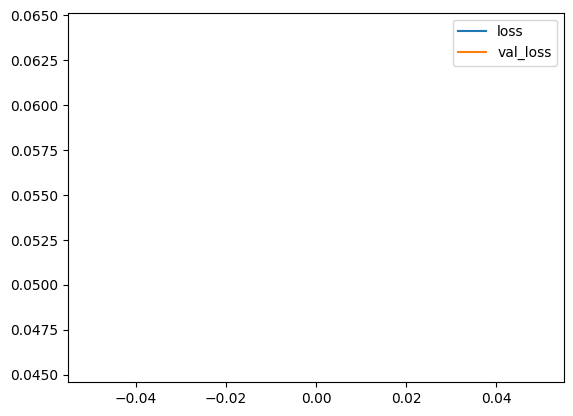

In [40]:
#Run for multiple epochs to plot this
plt.figure(figsize=(0,5))
pd.DataFrame(history.history).plot()
plt.show()

## 3. Make Predictions

In [43]:
text = vectorizer('You freaking suck! I am going to kill you')
res = model.predict(np.expand_dims(text,0))
res

1/1 [==============================] - 0s 123ms/step


array([[0.9857436 , 0.20586133, 0.8211777 , 0.10113395, 0.7557678 ,
        0.16273884]], dtype=float32)

In [46]:
batch_x, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_x) > 0.5).astype(int), batch_y

1/1 [==============================] - 0s 212ms/step


(array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

## 4. Evaluate Model

In [47]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [49]:
for batch in test.as_numpy_iterator():
    #unpack the batch
    x_true, y_true = batch
    #make a prediction
    yhat = model.predict(x_true)
    
    #flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    #
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 211ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 285ms/step


In [50]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8094754815101624, Recall: 0.6842105388641357, Accuracy: 0.48345035314559937


## 5. Test and Gradio

In [51]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
                                              0.0/19.7 MB ? eta -:--:--
                                              0.1/19.7 MB 4.3 MB/s eta 0:00:05
                                              0.3/19.7 MB 3.4 MB/s eta 0:00:06
                                              0.5/19.7 MB 3.7 MB/s eta 0:00:06
     -                                        0.8/19.7 MB 4.0 MB/s eta 0:00:05
     -                                        0.9/19.7 MB 4.1 MB/s eta 0:00:05
     --                                       1.2/19.7 MB 4.2 MB/s eta 0:00:05
     --                                       1.4/19.7 MB 4.4 MB/s eta 0:00:05
     ---                                      1.7/19.7 MB 4.5 MB/s eta 0:00:05
     ---                                      1.9/19.7 MB 4.5 MB/s eta 0:00:04
     ----                                     2.2/19.7 MB 4.7 MB/s eta 0:00:04
     -----                                    2.5/19.7 MB 4.6 MB/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-airflow 2.5.1 requires linkify-it-py>=2.0.0, but you have linkify-it-py 1.0.3 which is incompatible.


In [52]:
import gradio as gr

In [53]:
model.save('toxicity.h5')

In [54]:
model = tf.keras.models.load_model('toxicity.h5')

In [55]:
input_str = vectorizer('hello sucker')

In [58]:
model.predict(np.expand_dims(input_str,0)) 

1/1 [==============================] - 0s 134ms/step


array([[0.0823503 , 0.00031533, 0.01218534, 0.00608174, 0.01496836,
        0.00777732]], dtype=float32)

In [67]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    return text

In [68]:
interface = gr.Interface(fn=score_comment,\
                        inputs=gr.components.Textbox(lines=2, placeholder='Comment to score'),\
                        outputs = 'text')

In [70]:
interface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://a39af609db23ffa605.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 255ms/step
